## 20. 프로젝트 : Segmentation map으로 도로 이미지 만들기

이전 Pix2Pix 논문에서 제시한 결과 중에 아래와 같은 실험 결과가 있었습니다.   
**도로의 레이블 정보를 활용해 이미지를 생성**해낸 결과입니다.

<img style='align:center' width='70%' src='https://aiffelstaticprd.blob.core.windows.net/media/images/p2p_result_seg.max-800x600.png'/>

이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것입니다. 데이터셋은 아래에서 다운로드할 수 있습니다.
1000개의 학습용 이미지 및 5개의 평가 이미지를 포함합니다.

[cityscapes.zip](https://aiffelstaticprd.blob.core.windows.net/media/documents/cityscapes.zip)

이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 **레이블 정보 이미지를 입력으로 사용**하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없습니다.
아래 Tensroflow에서 제공하는 Pix2Pix 튜토리얼은 위 이미지와 비슷한 레이블 정보 이미지를 사용하기 때문에 좋은 참고 자료가 될 수 있을 것 같습니다.

프로젝트 시작에 어려움이 있다면 아래 튜토리얼을 참고하시면서 이번 프로젝트를 수행해봅시다.
(아래 튜토리얼은 Pix2Pix 구조를 **Functional API**를 이용해 구현하기 때문에 이번에 진행한 **Subclassing 방법**을 이용한 모델 구현과 비교하면서 구현 방법에 대해서도 공부해 보시길 추천드립니다)

[Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)


### 프로젝트 수행
프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같습니다.

1. 데이터에 한 가지 이상의 **augmentation 방법**을 적용하여 학습해주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 **U-Net Generator를 사용**해주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 **"val" 폴더 내 이미지를 사용**해주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 **10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨**주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

## 루브릭

|평가문항|	상세기준|
|:-------|:-------|
|1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.|데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.|
|2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.|U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.|
|3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.|10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.|

## 라이브러리 가져오기

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers, losses

from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import image
from tensorflow import data

## 데이터세트 로드하기

In [2]:
# 학습용 이미지 데이터 로드하기
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


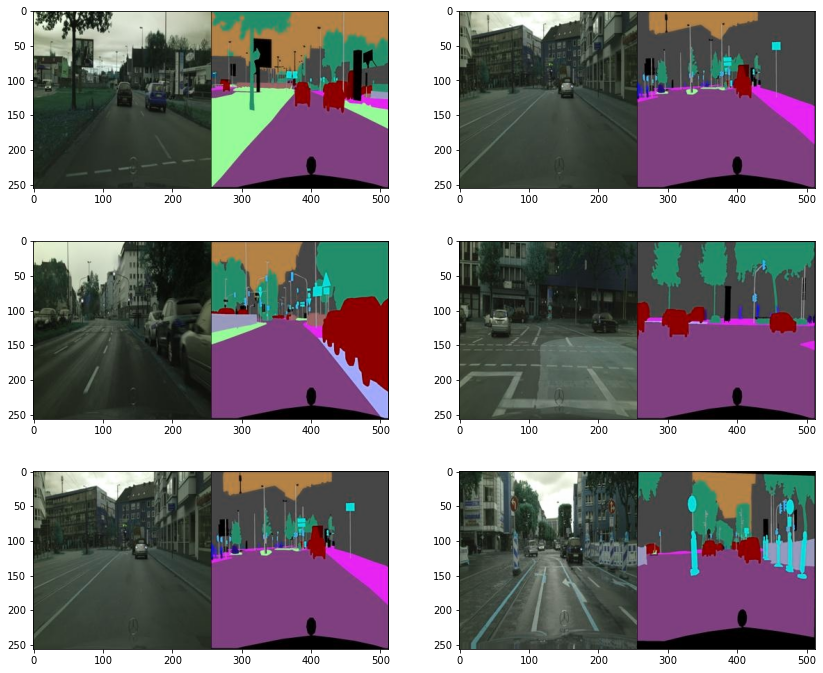

In [4]:
# 학습용 데이터셋에서 임의로 6장을 선택하여 시각화
plt.figure(figsize=(14,12))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(21)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [5]:
# 이미지 하나의 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


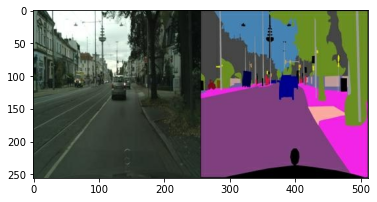

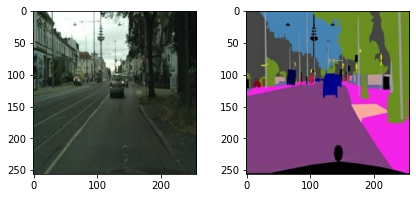

In [24]:
# (256, 256, 3) 크기의 2개 이미지로 분할
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :]                # 원본 이미지 영역
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]               # segmentation 이미지 영역
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

origin_img = tf.io.read_file(f)
origin_img = tf.image.decode_image(origin_img, 3)
plt.imshow(origin_img)

plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

* `tf.image.decode_image(img, 3)` :

## Data Augmentation

In [25]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    # 두 이미지가 채널 축으로 연결
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    # 50% 확률로 Refection padding 또는 constant padding
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    # 이미지를 임의로 잘라냄
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)  # 가로로 뒤집기
    out = image.random_flip_up_down(out)     # 세로로 뒤집기
    
    # 50% 확률로 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

* `tf.pad()` :
* `image.random_crop()` :
* `image.random_flip_left_right()` :
* `image.random_flip_up_down()` :
* `tf.random.uniform()` :

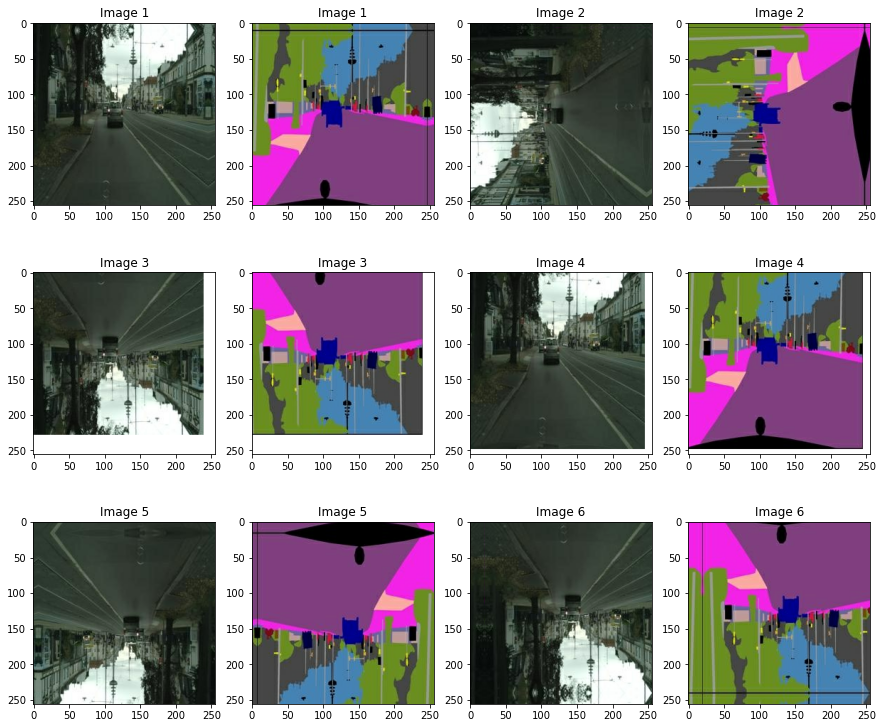

In [36]:
# Data Augmentation 함수 적용해 시각화 

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

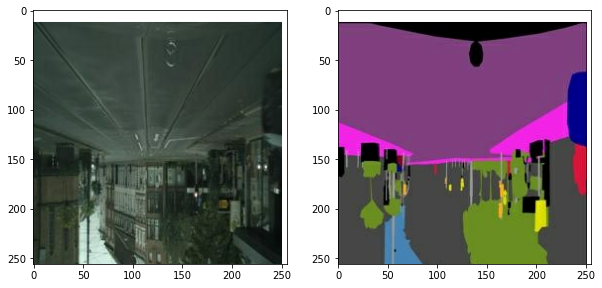

In [37]:
# 잘 적용되었는지 하나의 이미지만 시각화하여 확인

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

* `data.Dataset.list_files()` :

## U-Net generator 구현하기

In [53]:
# Encoder 및 Decoder에 사용되는 기본적인 블록
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, flt, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(flt, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [54]:
# U-Net Generator 정의
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, flt in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(flt, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(flt))
        
        self.decode_blocks = []
        for i, flt in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(flt))
            else:
                self.decode_blocks.append(DecodeBlock(flt, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


* `layers.Conv2DTranspose()` :

In [42]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Discriminator 구현하기

In [43]:
#  Discriminator에 사용할 기본적인 블록
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [44]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [45]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 손실함수 및 최적화 함수 정의

In [46]:
# 손실함수 정의
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [47]:
# 최적화 함수 정의
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [48]:
# 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    # gradient 계산
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gene_loss, l1_loss, disc_loss

## 모델 학습 진행

In [49]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0732                     
L1_loss:0.3076                     
Discriminator_loss:1.2569

EPOCH[1] - STEP[20]                     
Generator_loss:1.1453                     
L1_loss:0.2923                     
Discriminator_loss:0.9538

EPOCH[1] - STEP[30]                     
Generator_loss:1.0123                     
L1_loss:0.2610                     
Discriminator_loss:0.8643

EPOCH[1] - STEP[40]                     
Generator_loss:1.4479                     
L1_loss:0.2669                     
Discriminator_loss:0.7864

EPOCH[1] - STEP[50]                     
Generator_loss:1.9997                     
L1_loss:0.2468                     
Discriminator_loss:0.7046

EPOCH[1] - STEP[60]                     
Generator_loss:2.3824                     
L1_loss:0.2473                     
Discriminator_loss:0.5825

EPOCH[1] - STEP[70]                     
Generator_loss:1.8253                     
L1_loss:0.2292                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.8908                     
L1_loss:0.2335                     
Discriminator_loss:0.7504

EPOCH[3] - STEP[80]                     
Generator_loss:2.2350                     
L1_loss:0.1726                     
Discriminator_loss:0.8140

EPOCH[3] - STEP[90]                     
Generator_loss:3.6521                     
L1_loss:0.2087                     
Discriminator_loss:2.3078

EPOCH[3] - STEP[100]                     
Generator_loss:2.0883                     
L1_loss:0.1972                     
Discriminator_loss:0.3564

EPOCH[3] - STEP[110]                     
Generator_loss:1.4411                     
L1_loss:0.1902                     
Discriminator_loss:0.7107

EPOCH[3] - STEP[120]                     
Generator_loss:1.3740                     
L1_loss:0.2206                     
Discriminator_loss:0.7182

EPOCH[3] - STEP[130]                     
Generator_loss:2.4222                     
L1_loss:0.2068                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8190                     
L1_loss:0.2348                     
Discriminator_loss:1.1802

EPOCH[5] - STEP[140]                     
Generator_loss:1.1689                     
L1_loss:0.2060                     
Discriminator_loss:0.6686

EPOCH[5] - STEP[150]                     
Generator_loss:1.9235                     
L1_loss:0.2092                     
Discriminator_loss:0.6087

EPOCH[5] - STEP[160]                     
Generator_loss:1.4249                     
L1_loss:0.1657                     
Discriminator_loss:1.7275

EPOCH[5] - STEP[170]                     
Generator_loss:2.2180                     
L1_loss:0.2199                     
Discriminator_loss:0.9772

EPOCH[5] - STEP[180]                     
Generator_loss:0.8732                     
L1_loss:0.1833                     
Discriminator_loss:0.8454

EPOCH[5] - STEP[190]                     
Generator_loss:1.3386                     
L1_loss:0.1894             

EPOCH[7] - STEP[190]                     
Generator_loss:1.4970                     
L1_loss:0.1622                     
Discriminator_loss:0.7676

EPOCH[7] - STEP[200]                     
Generator_loss:1.9272                     
L1_loss:0.1708                     
Discriminator_loss:1.2406

EPOCH[7] - STEP[210]                     
Generator_loss:2.2942                     
L1_loss:0.2010                     
Discriminator_loss:0.3962

EPOCH[7] - STEP[220]                     
Generator_loss:1.4796                     
L1_loss:0.2002                     
Discriminator_loss:0.4485

EPOCH[7] - STEP[230]                     
Generator_loss:2.3484                     
L1_loss:0.1890                     
Discriminator_loss:0.4833

EPOCH[7] - STEP[240]                     
Generator_loss:2.7931                     
L1_loss:0.1722                     
Discriminator_loss:0.6153

EPOCH[7] - STEP[250]                     
Generator_loss:0.6110                     
L1_loss:0.2094             

EPOCH[9] - STEP[250]                     
Generator_loss:0.9649                     
L1_loss:0.1929                     
Discriminator_loss:0.6416

EPOCH[10] - STEP[10]                     
Generator_loss:2.1178                     
L1_loss:0.2066                     
Discriminator_loss:0.4531

EPOCH[10] - STEP[20]                     
Generator_loss:1.5065                     
L1_loss:0.2138                     
Discriminator_loss:0.5278

EPOCH[10] - STEP[30]                     
Generator_loss:1.6666                     
L1_loss:0.2203                     
Discriminator_loss:0.3580

EPOCH[10] - STEP[40]                     
Generator_loss:3.1977                     
L1_loss:0.1717                     
Discriminator_loss:0.6266

EPOCH[10] - STEP[50]                     
Generator_loss:1.8815                     
L1_loss:0.1566                     
Discriminator_loss:0.6787

EPOCH[10] - STEP[60]                     
Generator_loss:1.8090                     
L1_loss:0.1767             

## 검증용 데이터세트를 사용하여 생성하기

In [50]:
# 검증용 이미지 데이터 로드하기
val_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'
print("number of train examples :", len(os.listdir(val_path)))

number of train examples : 5


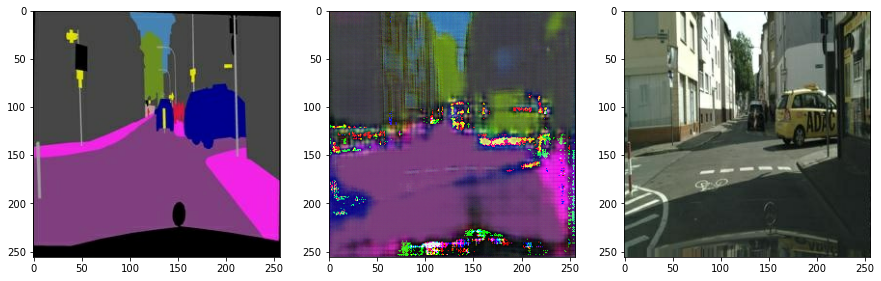

In [52]:
test_ind = 1

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(15,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

## 회고